In [14]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
                        #    '--xla_dump_to=xla_dump/')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

import arviz as az
import jax
import jax.experimental
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel, UniformTSubspace
from src.jax_test_model import MLPModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time
from jax_tqdm import scan_tqdm
from src.utils import get_cp_w, get_data, get_samples_from_run, get_model_from_run_path
from src.jax_subspace_curve import bezier_coeff_fn


%load_ext autoreload
%autoreload 2

%env XLA_FLAGS

#jax.devices("gpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'--xla_force_host_platform_device_count=10'

In [15]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### load data

Data shapes: (56, 1) (56,) (33, 1) (33,)


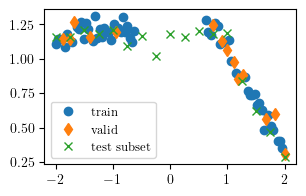

In [16]:
# load data
data = jnp.load('regression_data.npz')
x = jnp.array(data['x'])
y = jnp.array(data['y'])
x_test_ = jnp.array(data['xt'])
y_test_ = jnp.array(data['yt'])
# Split the data into training and validation sets
random_idx = jax.random.choice(random.PRNGKey(
    0), x.shape[0], (int(x.shape[0]*0.2),), replace=False)
x_val = x[random_idx]
y_val = y[random_idx]
x = x[np.setdiff1d(jnp.arange(x.shape[0]), random_idx)]
y = y[np.setdiff1d(jnp.arange(y.shape[0]), random_idx)]

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'd', label='valid')
# Plot a subset of the test data
subset_indices = jnp.arange(0, x_test_.shape[0], 2)
plt.plot(x_test_[subset_indices], y_test_[
         subset_indices], 'x', label='test subset')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test_.shape, y_test_.shape)

In [17]:
curve_params = {'k': 30,
                'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'relu'},
                'n_samples': 10,
                'lr': 0.001,
                'num_epochs': 10000,
                'use_validation': False,
                'out_scale': 0.05,
                'optimize_distparams': True
                }

Data shapes: (70, 1) (70,) (33, 1) (33,)


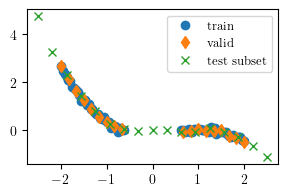

In [18]:
def gen_data(rng_seed, curve_params, **kwargs):
    rng_key = random.PRNGKey(rng_seed + 1133)
    x = jnp.linspace(-2, 2, 100)
    x = x[(jnp.abs(x) > 0.6)].reshape(-1, 1)

    # define ground trouth model
    rng_key, rng_init = random.split(rng_key)
    model_gen = MLPModel(**curve_params['model_kwargs'])
    params = model_gen.init(rng_init, x)

    # generate train data
    y_gt = model_gen.apply(params, x).squeeze()
    rng_key, rng = random.split(rng_key)
    y = y_gt + jax.random.normal(rng, y_gt.shape) * 0.05

    # generate valid data
    x_val = jnp.linspace(-2, 2, 25)
    x_val = x_val[(jnp.abs(x_val) > 0.6)].reshape(-1, 1)
    y_gt_val = model_gen.apply(params, x_val).squeeze()
    rng_key, rng = random.split(rng_key)
    y_val = y_gt_val + jax.random.normal(rng, y_gt_val.shape) * 0.05

    xt = jnp.linspace(-2.5, 2.5, 33).reshape(-1, 1)
    rng_key, rng = random.split(rng_key)
    y_gtt = model_gen.apply(params, xt).squeeze()
    yt = y_gtt + jax.random.normal(rng, y_gtt.shape) * 0.05

    return x, y, x_val, y_val, xt, yt, y_gtt


x, y, x_val, y_val, x_test_, y_test_, _ = gen_data(16, curve_params)

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'd', label='valid')
# Plot a subset of the test data
subset_indices = jnp.arange(0, x_test_.shape[0], 2)
plt.plot(x_test_[subset_indices], y_test_[
         subset_indices], 'x', label='test subset')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test_.shape, y_test_.shape)

In [19]:
bezier_coeff_inv = bezier_coeff_fn(curve_params['k'])


def get_d_bezier(t):
    coeff = jax.vmap(bezier_coeff_inv)(t)

    def clousure(cp):
        n = cp.shape[0] - 1
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('tj,j...->t...', coeff, cp_diff) * n
    return clousure


@jit
def bezier_length(cp):
    t = jnp.linspace(0, 1, 1000)
    d_bezier = get_d_bezier(t)
    d_t = jnp.linalg.norm(d_bezier(cp), axis=-1)
    length = jax.scipy.integrate.trapezoid(d_t, t)
    return length

### ascending bias functions

In [20]:
rng_key = random.PRNGKey(0)
rng_key, sample_key = jax.random.split(rng_key)
s = jax.random.normal(sample_key, (1000000,))/10 - 4.6
jax.nn.softplus(s).mean(), jax.nn.softplus(s).std()

(Array(0.01005001, dtype=float32), Array(0.00100188, dtype=float32))

In [21]:
@jit
def up_sorted(b):
    bb = jax.nn.softplus(b)
    bb = bb.at[..., 0].set(b[..., 0])
    # b = b.at[..., 1:].apply(jax.nn.softplus) # because of derivative error of apply softplus (scatter_apply JVP not implemented)
    return jnp.cumsum(bb, axis=-1)
    # return bb @ jnp.tri(bb.shape[-1]).T       # slower

def print_all_biases(p):
    def print_bias(path, p):
        if "bias" in path[-1].key:
            print(f"bias {p}")
    jax.tree_util.tree_map_with_path(print_bias, p)

@jit
def bias_ascending(params):
    def bias_sort(path, p):
        if "bias" in path[-1].key:
            return up_sorted(p)
        else:
            return p
    return jax.tree_util.tree_map_with_path(bias_sort, params)

def initialize_bias(rng_key, params):
    key = rng_key
    def bias_sorted_init(path, p):
        nonlocal key
        # if "bias" in path[-1].key:
        #     key, sample_key = jax.random.split(key)
        #     b = jax.random.normal(sample_key, (p.shape[-1]-1,))-2.68
        #     p = p.at[..., 1:].set(b)
        #     p = p.at[..., 0].set(-0.1*p.shape[1]/2)
        #     return p
        # if "bias" in path[-1].key:
        #     key, sample_key = jax.random.split(key)
        #     b = jax.random.normal(sample_key, (p.shape[-1]-1,))/10-4.6
        #     p = p.at[..., 1:].set(b)
        #     p = p.at[..., 0].set(-0.01*p.shape[1]/2)
        #     return p
        if "bias" in path[-1].key:
            key, sample_key = jax.random.split(key)
            b = jax.random.normal(sample_key, (p.shape[-1]-1,))/10-100
            p = p.at[..., 1:].set(b)
            p = p.at[..., 0].set(-0.0*p.shape[1]/2)
            return p
        else:
            return p
    return jax.tree_util.tree_map_with_path(bias_sorted_init, params)

b = jax.random.normal(rng_key, (3, 5))
b, up_sorted(b)

(Array([[ 1.8429084 ,  1.2368948 ,  0.6249425 ,  1.2353886 , -1.0533676 ],
        [-0.37084433,  0.30201778, -0.3027605 ,  0.6017325 ,  1.0271428 ],
        [-0.39748248,  0.05069933,  1.2804588 , -0.07814798, -1.4377463 ]],      dtype=float32),
 Array([[ 1.8429084 ,  3.3346658 ,  4.388329  ,  5.878919  ,  6.178106  ],
        [-0.37084433,  0.48467055,  1.0378519 ,  2.076459  ,  3.4096358 ],
        [-0.39748248,  0.32133564,  1.8470203 ,  2.5018568 ,  2.7149196 ]],      dtype=float32))

In [22]:
class SubspaceModelPermFree(SubspaceModel):
    @partial(jit, static_argnums=(0,))
    def __call__(self, params, t, x):
        """
        Computes the output of the model for given parameters, time, and input.

        Parameters:
        - params: The parameters of the model.
        - t: The time parameter.
        - x: The input data.

        Returns:
        - The output of the model.

        """
        # sample Bezier coefficient
        bezier_coeff = self.bezier(t)
        # Compute one parameter set per sample
        sample_param = jax.tree.map(lambda p: jnp.einsum(
            'sk,k...->s...', bezier_coeff, p), params)
        sample_param = dict(params=sample_param)
        # transform biases' into bias which is sorted in ascending order 
        sample_param = bias_ascending(sample_param)
        # forward pass per sample
        out = jax.vmap(self.model.apply, in_axes=(0, None))(sample_param, x)
        return out
    

### Bias ordering comparision

#### with bias sorting

In [23]:
# define model architecture
model = MLPModel(**curve_params['model_kwargs'])

# define the subspace model to optimize the path
s_model = SubspaceModelPermFree(model,  # any model can be passed
                                k=curve_params['k'],
                                n_samples=curve_params['n_samples'],
                                out_scale=curve_params['out_scale'],
                                optimize_distparams=curve_params['optimize_distparams'])

rng_key = random.PRNGKey(0)
rng_key, init_key = random.split(rng_key)
params_prime = s_model.init_params(init_key, x)

# initialize bias for ascending order
rng_key, init_key = random.split(rng_key)
params_prime = initialize_bias(init_key, params_prime)

# optimizer
optimizer = optax.adam(learning_rate=curve_params['lr'])
# dnn_parameters + dist_parameters
opt_state = optimizer.init(params_prime)


def comp_metric_set(x, y):
    return lambda subkey, params: s_model.compute_loss(
        subkey, params, x, y, n_samples=1000)
comp_metric = comp_metric_set(x_val, y_val)


# train loop
@scan_tqdm(curve_params['num_epochs'])
def train(carry, _):
    rng_key, params, opt_state, best_loss, best_params, epoch, epoch_sel = carry
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(
        subkey, params, x, y, opt_state, optimizer)
    # validate
    rng_key, subkey = random.split(rng_key)
    val_loss = comp_metric(subkey, params)
    best_params, epoch_sel = jax.lax.cond(
        val_loss < best_loss, lambda x: (params, epoch), lambda x: (best_params, epoch_sel), None)
    best_loss = jnp.minimum(best_loss, val_loss)

    cp_w = pytree_to_matrix(bias_ascending(params['params']), curve_params['k'])
    length = bezier_length(cp_w)
    return (rng_key, params, opt_state, best_loss, best_params, epoch+1, epoch_sel), (loss, val_loss, length, epoch)


carry = (rng_key, params_prime, opt_state, np.inf, params_prime, 0, -1)
carry, (losses, valid_losses, length, epochs) = jax.lax.scan(train, carry,
                                                             jnp.arange(curve_params['num_epochs']))

  0%|          | 0/10000 [00:00<?, ?it/s]

Array(-1.738328, dtype=float32)

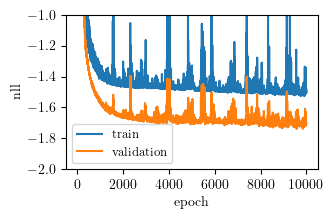

In [24]:
# fast overfitting
plt.plot(losses, label='train')
plt.plot(valid_losses, label='validation')
plt.legend()
plt.ylabel("nll")
plt.xlabel("epoch")
# plt.yscale('log')
plt.ylim(-2, -1.)
np.min(valid_losses)

Text(0.5, 0, 'epoch')

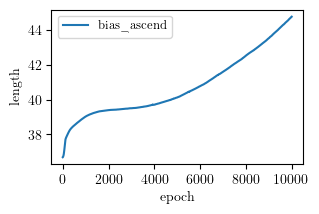

In [25]:
plt.plot(epochs, length, label='bias_ascend')
plt.legend()
plt.ylabel("length")
plt.xlabel("epoch")
# plt.yscale('log')
# plt.ylim(-2, -1.)

In [26]:
params_prime = carry[4]
# get transformed bias params
params = bias_ascending(params_prime)

# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params['params'], curve_params['k'])
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

Control points in phi space: (31, 30)


In [27]:
curve, d_curve = bezier_curve(curve_params['k']+1, cp_w)
t = jnp.linspace(0, 1, 1000)

def get_bias(t, layer):
    pt = vec_to_pytree(curve(t), params['params'])
    return pt[layer]['bias']


biases = []
for layer in params['params'].keys():
    bias = jax.vmap(get_bias, in_axes=(0, None))(t, layer)
    biases.append(bias)

biases[0].shape

(1000, 16)

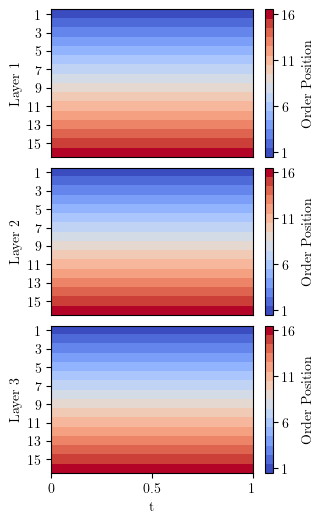

In [28]:
from matplotlib.colors import ListedColormap
# Select SV
def get_sorted_orderings(biases, layer):
    sv_data = biases[layer]  # Shape: (Layer, Epochs, nrUnits)

    # Step 1: Compute the order of the parameters for all epochs
    orderings = np.argsort(sv_data, axis=1)  # Shape: (Epochs, nrUnits)
    # Compute the average order for each parameter
    average_order = np.mean(orderings, axis=0)
    # Sort the parameters based on the average order
    sorted_indices = np.argsort(average_order)
    return orderings[:, sorted_indices].T, sorted_indices


fig, axes = plt.subplots(3, 1, figsize=(figsize[0], figsize[1]*3))

for i, ax in enumerate(axes):
    orderings, sorted_indices = get_sorted_orderings(biases, i)
    num_bias = biases[i].shape[1]

    # Define a discrete colormap with 16 colors representing the order positions
    cmap = ListedColormap(plt.get_cmap('coolwarm', num_bias)
                          (np.arange(num_bias)[sorted_indices])) # reorder colors for correct color mapping
    # cmap = plt.get_cmap('coolwarm', num_bias)

    # Create the heatmap where rows are parameters and columns are epochs
    img = ax.imshow(orderings, aspect='auto',
                    interpolation='nearest', cmap=cmap)

    # Customize the colorbar to represent the order positions
    cbar = plt.colorbar(img, label='Order Position')
    cbar.set_ticks(np.linspace(0.5, num_bias-1.5, 4))
    cbar.set_ticklabels(np.arange(1, num_bias+1, 5))

    ax.set_yticks(np.arange(0, num_bias, 2))
    ax.set_yticklabels(np.arange(1, num_bias+1, 2))
    ax.set_xticks([0,len(t)/2, len(t)-1])
    ax.set_xticklabels([0, 0.5, 1])

axes[-1].set_xlabel('t')
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[0].set_ylabel('Layer 1')
axes[1].set_ylabel('Layer 2')
axes[2].set_ylabel('Layer 3')
plt.subplots_adjust(hspace=0.07)
plt.savefig("figures/ascending_ordering_permFree.pdf", bbox_inches='tight')

(1000, 500)


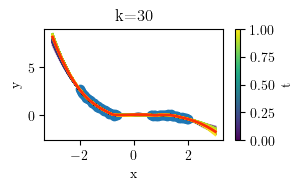

In [29]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(params_prime['params'], t_space, x_lin).squeeze(axis=-1)
print(out.shape)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={curve_params['k']}")
plt.tight_layout()

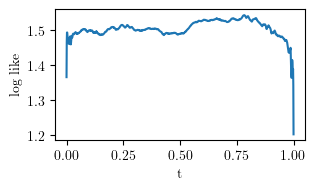

In [30]:
fig, ax = plt.subplots()
t_space = jnp.linspace(0.0, 1.0, 1000)
ll = -s_model.nll(params_prime, t_space, x, y).mean(axis=-1)
ax.plot(t_space, ll)
ax.set_xlabel("t")
ax.set_ylabel("log like")
plt.tight_layout()

In [31]:
rng_key = carry[0]
rng_key, subkey = jax.random.split(rng_key)
test_loss = s_model.compute_loss(
    subkey, params_prime, x_test_, y_test_, n_samples=100000)
test_loss

Array(-0.8114223, dtype=float32)

#### vanilla training 
without bias ascending

In [32]:
# define model architecture
model = MLPModel(**curve_params['model_kwargs'])

# define the subspace model to optimize the path
s_model = SubspaceModel(model,  # any model can be passed
                                k=curve_params['k'],
                                n_samples=curve_params['n_samples'],
                                out_scale=curve_params['out_scale'],
                                optimize_distparams=curve_params['optimize_distparams'])

rng_key = random.PRNGKey(0)
rng_key, init_key = random.split(rng_key)
params = s_model.init_params(init_key, x)

# optimizer
optimizer = optax.adam(learning_rate=curve_params['lr'])
# dnn_parameters + dist_parameters
opt_state = optimizer.init(params)


def comp_metric_set(x, y):
    return lambda subkey, params: s_model.compute_loss(
        subkey, params, x, y, n_samples=1000)
comp_metric = comp_metric_set(x_val, y_val)


# train loop
@scan_tqdm(curve_params['num_epochs'])
def train(carry, _):
    rng_key, params, opt_state, best_loss, best_params, epoch, epoch_sel = carry
    rng_key, subkey = random.split(rng_key)
    loss, params, opt_state = s_model.train_step(
        subkey, params, x, y, opt_state, optimizer)
    # validate
    rng_key, subkey = random.split(rng_key)
    val_loss = comp_metric(subkey, params)
    best_params, epoch_sel = jax.lax.cond(
        val_loss < best_loss, lambda x: (params, epoch), lambda x: (best_params, epoch_sel), None)
    best_loss = jnp.minimum(best_loss, val_loss)

    cp_w = pytree_to_matrix(bias_ascending(params['params']), curve_params['k'])
    length = bezier_length(cp_w)
    return (rng_key, params, opt_state, best_loss, best_params, epoch+1, epoch_sel), (loss, val_loss, length, epoch)


carry = (rng_key, params, opt_state, np.inf, params, 0, -1)
carry, (losses_nb, valid_losses_nb, length_nb, epochs_nb) = jax.lax.scan(train, carry,
                                                             jnp.arange(curve_params['num_epochs']))

  0%|          | 0/10000 [00:00<?, ?it/s]

(-2.0, -1.0)

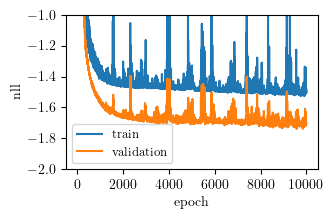

In [33]:
# fast overfitting
plt.plot(losses, label='train')
plt.plot(valid_losses, label='validation')
plt.legend()
plt.ylabel("nll")
plt.xlabel("epoch")
# plt.yscale('log')
plt.ylim(-2, -1.)

(-2.0, -1.0)

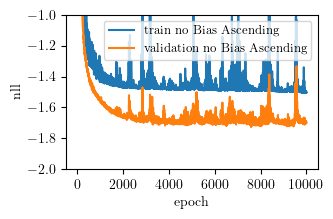

In [34]:
# fast overfitting
plt.plot(losses_nb, label='train no Bias Ascending')
plt.plot(valid_losses_nb, label='validation no Bias Ascending')
plt.legend()
plt.ylabel("nll")
plt.xlabel("epoch")
# plt.yscale('log')
plt.ylim(-2, -1.)

Text(0.5, 0, 'epoch')

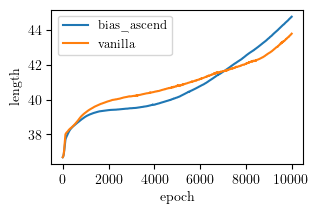

In [35]:
# fast overfitting
plt.plot(epochs, length, label='bias_ascend')
plt.plot(epochs_nb, length_nb, label='vanilla')
plt.legend()
plt.ylabel("length")
plt.xlabel("epoch")
# plt.yscale('log')
# plt.ylim(-2, -1.)

In [36]:
params = carry[4]

# get design matrix from curve parameters stroed as pytree
cp_w = pytree_to_matrix(params['params'], curve_params['k'])
# define the transformation function between weight space and phi space
t_phi_to_weight = OrthoSpan(cp_w)
# control points in the varphi space
cp_phi = t_phi_to_weight.inv(cp_w)
print(f"Control points in phi space: {cp_phi.shape}")

Control points in phi space: (31, 30)


In [37]:
curve, d_curve = bezier_curve(curve_params['k']+1, cp_w)
t = jnp.linspace(0, 1, 1000)

def get_bias(t, layer):
    pt = vec_to_pytree(curve(t), params['params'])
    return pt[layer]['bias']


biases = []
for layer in params['params'].keys():
    bias = jax.vmap(get_bias, in_axes=(0, None))(t, layer)
    biases.append(bias)

biases[0].shape

(1000, 16)

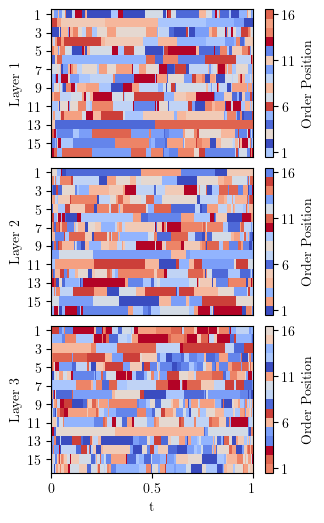

In [38]:
from matplotlib.colors import ListedColormap
# Select SV
def get_sorted_orderings(biases, layer):
    sv_data = biases[layer]  # Shape: (Layer, Epochs, nrUnits)

    # Step 1: Compute the order of the parameters for all epochs
    orderings = np.argsort(sv_data, axis=1)  # Shape: (Epochs, nrUnits)
    # Compute the average order for each parameter
    average_order = np.mean(orderings, axis=0)
    # Sort the parameters based on the average order
    sorted_indices = np.argsort(average_order)
    return orderings[:, sorted_indices].T, sorted_indices


fig, axes = plt.subplots(3, 1, figsize=(figsize[0], figsize[1]*3))

for i, ax in enumerate(axes):
    orderings, sorted_indices = get_sorted_orderings(biases, i)
    num_bias = biases[i].shape[1]

    # Define a discrete colormap with 16 colors representing the order positions
    cmap = ListedColormap(plt.get_cmap('coolwarm', num_bias)
                          (np.arange(num_bias)[sorted_indices])) # reorder colors for correct color mapping
    # cmap = plt.get_cmap('coolwarm', num_bias)

    # Create the heatmap where rows are parameters and columns are epochs
    img = ax.imshow(orderings, aspect='auto',
                    interpolation='nearest', cmap=cmap)

    # Customize the colorbar to represent the order positions
    cbar = plt.colorbar(img, label='Order Position')
    cbar.set_ticks(np.linspace(0.5, num_bias-1.5, 4))
    cbar.set_ticklabels(np.arange(1, num_bias+1, 5))

    ax.set_yticks(np.arange(0, num_bias, 2))
    ax.set_yticklabels(np.arange(1, num_bias+1, 2))
    ax.set_xticks([0, len(t)/2, len(t)-1])
    ax.set_xticklabels([0, 0.5, 1])

axes[-1].set_xlabel('t')
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[0].set_ylabel('Layer 1')
axes[1].set_ylabel('Layer 2')
axes[2].set_ylabel('Layer 3')
plt.subplots_adjust(hspace=0.07)
plt.savefig("figures/ascending_ordering_noSorting.pdf", bbox_inches='tight')

(1000, 500)


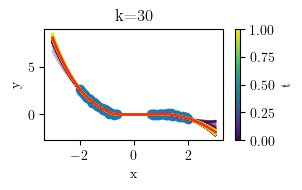

In [39]:
# plot predictive for onedimensional regression dataset
fig, ax = plt.subplots()
t_space = jnp.linspace(0, 1, 1000)
x_lin = jnp.linspace(-3, 3, 500)[:, None]
out = s_model(params['params'], t_space, x_lin).squeeze(axis=-1)
print(out.shape)
ax.plot(x, y, 'o', label='train')
# plt.fill_between(x.squeeze(), out.mean(axis=0) - out.std(axis=0), out.mean(axis=0) + out.std(axis=0), alpha=0.5)
# plot lines using viridis color map
colors = plt.cm.viridis(t_space)
for o, c in zip(out, colors):
    ax.plot(x_lin, o, color=c, alpha=0.3)
ax.plot(x_lin, out.mean(axis=0), label='mean',
        c='red', linewidth=2, alpha=0.8)
ax.set_ylabel("y")
ax.set_xlabel("x")
# add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(
    vmin=t_space.min(), vmax=t_space.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('t')
plt.title(f"k={curve_params['k']}")
plt.tight_layout()

In [40]:

rng_key = carry[0]
rng_key, subkey = jax.random.split(rng_key)
test_loss = s_model.compute_loss(subkey, params, x_test_, y_test_, n_samples=100000)
test_loss

Array(-1.1557214, dtype=float32)

### wandb compare

In [41]:
api = wandb.Api()
results = []
# for s_id in ['vl6382k1', 'x26ip745', 'd8bi25u9']:
for s_id in ['paxv2kno', 'u7vfztsz', '43684y5h']:
    t_bar = tqdm(api.sweep(f"ddold/subspace_toy_reg/{s_id}").runs)
    t_bar.set_description(f"Sweep id: {s_id}")
    for run in t_bar:
        if (run.state == 'finished'):
            t_bar.set_postfix_str(run.name)
            res = dict(Id=run.id,
                       Activation=run.config['curve_params']['model_kwargs']['activation'],
                       Depth=run.config['curve_params']['model_kwargs']['depth'],
                       SubspaceDim=run.config['curve_params']['k'],
                       Seed=run.config['rng_seed'],
                       SelectFromValidation=run.config['curve_params']['use_validation'],
                       UniformSSampling=run.config['curve_params']['uniform_t_optimize'],
                       Bias="Sorted" if run.config['curve_params'].get(
                           'bias_ascending_dnn', False) else "Vanilla",
                       curve_ll_train=run.summary.get(
                           'curve_log_likelihood', -np.inf),
                       curve_ll_val=-run.summary.get('best_loss', np.inf),
                       )
            results.append(res)
        else:
            print(
                f"Encoundert problem with run {run.name}; state: {run.state}")
df = pd.DataFrame(results)
df

Sweep id: 43684y5h: 100%|██████████| 150/150 [00:00<00:00, 540.58it/s, tough-sweep-2]         


Encoundert problem with run stellar-sweep-1; state: crashed


,Id,Activation,Depth,SubspaceDim,Seed,SelectFromValidation,UniformSSampling,Bias,curve_ll_train,curve_ll_val
0,1pxmenf1,elu,3,20,14,True,False,Vanilla,1.585872,1.340081
1,ewlsu489,elu,3,20,13,True,False,Vanilla,1.541566,1.642239
2,ie7gv09t,elu,3,20,12,True,False,Vanilla,1.538396,1.550324
3,g77awjzj,elu,3,20,11,True,False,Vanilla,1.677180,1.546046
4,pyzexfx4,elu,3,20,10,True,False,Vanilla,1.634015,1.584967
...,...,...,...,...,...,...,...,...,...,...
444,5uuh53fk,relu,3,2,15,True,True,Sorted,1.455241,1.249192
445,e9cgy0qz,relu,3,2,14,True,True,Sorted,1.596452,1.246634
446,4nbbbk0f,relu,3,2,13,True,True,Sorted,1.515058,1.552647
447,w8vu26ob,relu,3,2,12,True,True,Sorted,1.585658,1.563393


In [42]:
# runs with problems
idx_config_with_nan = df.isnull().values.any(axis=1)
df[idx_config_with_nan]

,Id,Activation,Depth,SubspaceDim,Seed,SelectFromValidation,UniformSSampling,Bias,curve_ll_train,curve_ll_val


In [43]:
df_clean = df[~idx_config_with_nan]
idx_ids = [col for col in df.columns if col[0].isupper()]
value_ids = np.setdiff1d(df.columns.values, idx_ids)
print("Unique configuartions: ")
variable_idx = []
for c in df_clean.columns:
    if c not in [*value_ids, 'Id']:
        unique_ = df_clean[c].unique()
        print(c, unique_)
        if (len(unique_) > 1) and (c != 'Seed'):
            variable_idx.append(c)
print(f"\nExperiment differs in {variable_idx} configs")

Unique configuartions: 
Activation ['elu' 'relu']
Depth [3]
SubspaceDim [20  4 10  7  2]
Seed [14 13 12 11 10 24 23 21 20 19 16 22 18 17 15]
SelectFromValidation [ True]
UniformSSampling [False  True]
Bias ['Vanilla' 'Sorted']

Experiment differs in ['Activation', 'SubspaceDim', 'UniformSSampling', 'Bias'] configs


In [44]:
df_subset = df_clean[df_clean['UniformSSampling'] == True]

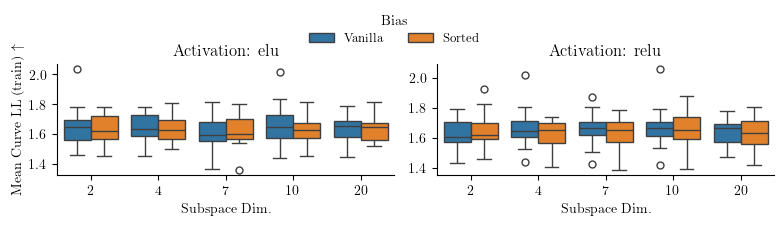

In [45]:
from matplotlib import colors

g = sns.catplot(data=df_subset, y='curve_ll_train', x='SubspaceDim',
                col='Activation', kind='box', hue='Bias', sharey=False, height=figsize[1], aspect=2, palette='tab10',)
g.set_titles(row_template='--- {row_name}',
             col_template='Activation: {col_name}')
for ax in g.axes.flatten():
    title = ax.get_title()
    new_title = title.replace('lambda', 'Tunnel').replace('varphi', 'Volume')
    ax.set_title(new_title)
# set ylim
# for ax in g.axes.flatten():
#     ax.set_ylim(-2, 2)
g.axes[0, 0].set_xlabel('Subspace Dim.')
g.axes[0, 1].set_xlabel('Subspace Dim.')
g.axes[0, 0].set_ylabel(r'Mean Curve LL (train) $\uparrow$')
# g.axes[1, 0].set_ylabel('LPPD')
# Update legend labels
for t in g._legend.texts:
    t.set_text(t.get_text().split('.')[0])
g.tight_layout()
sns.move_legend(g, loc='upper center', bbox_to_anchor=(.45, 1.13), ncols=6)
plt.savefig('figures/subspace_BiasSorting_train.pdf', bbox_inches='tight')

In [47]:
# Display the table for df_subset
df_subset_mean = df_subset.groupby(['Activation', 'SubspaceDim', 'Bias'])['curve_ll_train'].agg(['mean', 'std'])
df_subset_mean = df_subset_mean.assign(
    mean_curve_LL=lambda x: x['mean'].round(2).apply(
        lambda y: f"{y:.2f}") + " ± " + x['std'].round(2).apply(lambda y: f"{y:.2f}"),
    ).drop(columns=['mean', 'std',])  # [['lppd_test',]]

df_subset_mean.reset_index(drop=False).to_markdown()

'|    | Activation   |   SubspaceDim | Bias    | mean_curve_LL   |\n|---:|:-------------|--------------:|:--------|:----------------|\n|  0 | elu          |             2 | Sorted  | 1.64 ± 0.10     |\n|  1 | elu          |             2 | Vanilla | 1.65 ± 0.14     |\n|  2 | elu          |             4 | Sorted  | 1.63 ± 0.09     |\n|  3 | elu          |             4 | Vanilla | 1.64 ± 0.10     |\n|  4 | elu          |             7 | Sorted  | 1.62 ± 0.11     |\n|  5 | elu          |             7 | Vanilla | 1.61 ± 0.11     |\n|  6 | elu          |            10 | Sorted  | 1.63 ± 0.09     |\n|  7 | elu          |            10 | Vanilla | 1.66 ± 0.15     |\n|  8 | elu          |            20 | Sorted  | 1.63 ± 0.08     |\n|  9 | elu          |            20 | Vanilla | 1.63 ± 0.09     |\n| 10 | relu         |             2 | Sorted  | 1.65 ± 0.13     |\n| 11 | relu         |             2 | Vanilla | 1.62 ± 0.11     |\n| 12 | relu         |             4 | Sorted  | 1.62 ± 0.10  

|    | Activation | Subspace Dim. | Bias ascending | mean curve LL |
|---:|:-----------|------------:|:--------------|:--------------|
|  0 | elu        |           2 | False         | 1.65 ± 0.14   |
|  1 | elu        |           2 | True          | 1.64 ± 0.10   |
|  2 | elu        |           4 | False         | 1.64 ± 0.10   |
|  3 | elu        |           4 | True          | 1.63 ± 0.09   |
|  4 | elu        |           7 | False         | 1.61 ± 0.11   |
|  5 | elu        |           7 | True          | 1.62 ± 0.11   |
|  6 | elu        |          10 | False         | 1.66 ± 0.15   |
|  7 | elu        |          10 | True          | 1.63 ± 0.09   |
|  8 | elu        |          20 | False         | 1.63 ± 0.09   |
|  9 | elu        |          20 | True          | 1.63 ± 0.08   |
| 10 | relu       |           2 | False         | 1.62 ± 0.11   |
| 11 | relu       |           2 | True          | 1.65 ± 0.13   |
| 12 | relu       |           4 | False         | 1.66 ± 0.14   |
| 13 | relu       |           4 | True          | 1.62 ± 0.10   |
| 14 | relu       |           7 | False         | 1.66 ± 0.11   |
| 15 | relu       |           7 | True          | 1.63 ± 0.12   |
| 16 | relu       |          10 | False         | 1.67 ± 0.14   |
| 17 | relu       |          10 | True          | 1.65 ± 0.12   |
| 18 | relu       |          20 | False         | 1.64 ± 0.10   |
| 19 | relu       |          20 | True          | 1.63 ± 0.12   |


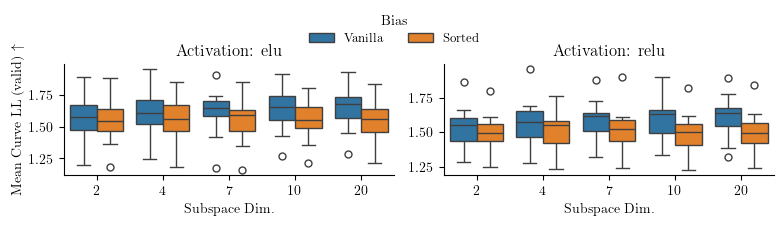

In [48]:
from matplotlib import colors

g = sns.catplot(data=df_subset, y='curve_ll_val', x='SubspaceDim',
                col='Activation', kind='box', hue='Bias', sharey=False, height=figsize[1], aspect=2, palette='tab10',)
g.set_titles(row_template='--- {row_name}',
             col_template='Activation: {col_name}')
for ax in g.axes.flatten():
    title = ax.get_title()
    new_title = title.replace('lambda', 'Tunnel').replace('varphi', 'Volume')
    ax.set_title(new_title)
# set ylim
# for ax in g.axes.flatten():
#     ax.set_ylim(-2, 2)
g.axes[0, 0].set_xlabel('Subspace Dim.')
g.axes[0, 1].set_xlabel('Subspace Dim.')
g.axes[0, 0].set_ylabel(r'Mean Curve LL (valid) $\uparrow$')
# g.axes[1, 0].set_ylabel('LPPD')
# Update legend labels
for t in g._legend.texts:
    t.set_text(t.get_text().split('.')[0])
g.tight_layout()
sns.move_legend(g, loc='upper center', bbox_to_anchor=(.45, 1.13), ncols=6)
plt.savefig('figures/subspace_BiasSorting_valid.pdf', bbox_inches='tight')